# ECG Heartbeat Classification EDA

### Background information
- **Electrocardiogram(ECG)** measures the hearts electrical activity of the heart.
- According to (Kachuee et al., 2018), Manual ECG review are difficult when detecting and categorizing different waveforms and morphologies

#### How does a heartbeat look like in a ECG signal?

To answer that, we must understand the different parts of the wave:
* __P-wave__: Starts the heartbeat, the atria(upper chamber) is contracting
* __PR interval__: Repersents the time it takes for the electical move between the __atria and the ventricle__. This time repersents the heart __natural pacemaker__.
* __QRS Complex__: Basically the beat, the sharp spike, this is when the __ventricle__ contracts and pushes blood through the body
* __ST segment__: The heart is basically relaxing here before the next heartbeat
* __T wave__: The final wave -- repolarization of the ventricles, preparing for the next heart beat

These shapes are what the machine learning model will learn to predict what is __normal__ vs __abnormal__.

### Figure 1
![ECG Heartbeat](./images/heatbeat.png)

### Objective 
1. Understand the ECG heartbeat patterns, such that, their __statistical and morphological differences__, can build a model that __reliably detects anomalies__ within the waves, and those anomolies can be classified.


### Dataset Summary
__Arrhythmia Dataset__
* __Samples__: 109446 rows
* __5 Classes__: N(normal), S(Supraventricular), V(Ventricular), F(Fusion), Q(Unclassfied)
* __Duration of the signal(row)__: 188 time steps / 125Hz

Each row corrosponds to one heart beat, at ~1.5s in duration

In [38]:
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.signal import find_peaks

### Variables

In [16]:
%pwd

'/home/Github/MachineLearningPortfolio/ECG_Classification'

In [17]:
# Constants related to the data
FS = 125
CLASSES = {0: "N", 1: "S", 2: "V", 3: "F", 4: "Q"}
RANDOM_SEED = 42

# Paths to data ECG_Classification/.data/mitbih_train.csv
mitbih_train_path = "./.data/mitbih_train.csv"
mitbih_test_path = "./.data/mitbih_test.csv"

### Exploratory Data Analysis(EDA)
- both mitbih and ptbdb contain enough data to train a deep learning model.
- I believe the ptbdb contains categories that contains heart attacks -- myocardial infractions
- Also, the last column should indicate what the heart beat is classified as

In [18]:
### Data cleaning and integrity verification

In [19]:
# Loading the data
mitbih_train_df = pd.read_csv(mitbih_train_path, header=None)

In [20]:
mitbih_train_df.shape

(87554, 188)

In [21]:
mitbih_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87554 entries, 0 to 87553
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 125.6 MB


In [22]:
mitbih_train_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
count,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,...,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000
mean,0.890360,0.758160,0.423972,0.219104,0.201127,0.210399,0.205808,0.201773,0.198691,0.196757,...,0.005025,0.004628,0.004291,0.003945,0.003681,0.003471,0.003221,0.002945,0.002807,0.473376
std,0.240909,0.221813,0.227305,0.206878,0.177058,0.171909,0.178481,0.177240,0.171778,0.168357,...,0.044154,0.042089,0.040525,0.038651,0.037193,0.036255,0.034789,0.032865,0.031924,1.143184
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.921922,0.682486,0.250969,0.048458,0.082329,0.088416,0.073333,0.066116,0.065000,0.068639,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.991342,0.826013,0.429472,0.166000,0.147878,0.158798,0.145324,0.144424,0.150000,0.148734,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.910506,0.578767,0.341727,0.258993,0.287628,0.298237,0.295391,0.290832,0.283636,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000


In [23]:
# Checking if the last column is actually the classification
classes_freq = mitbih_train_df.iloc[:, -1].value_counts()
print(type(classes_freq))
sorted_classes_freq = classes_freq.sort_index()
sorted_classes_freq

<class 'pandas.core.series.Series'>


187
0.0    72471
1.0     2223
2.0     5788
3.0      641
4.0     6431
Name: count, dtype: int64

Text(0, 0.5, 'Frequency of Classes')

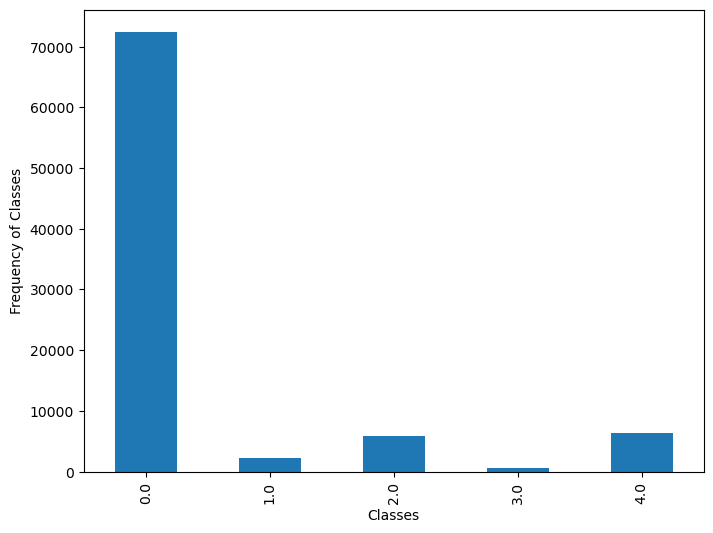

In [24]:
plt.figure(figsize=(8, 6))
sorted_classes_freq.plot(kind="bar")
plt.xlabel("Classes")
plt.ylabel("Frequency of Classes")

### What might the freq of classes mean?
- The problematic classes are S and F, there is a imbalance, and we probably need some sort of way to increase the recall for class S and F.
- The __solution__ is to do __SMOTE__, in this case, we increase the recall, as in, we are able to detect almost all of S and F. If we do this approach, the SMOTE technique to atrifically create data for classes S and F, and S and F are clustered close to the other classes, SMOTE will make S and F appear as a bigger cluster, and the model might consider other classes as S or F.

### Sanity Check
- Checking for missing values

In [25]:
missing_value_count = mitbih_train_df.isna().sum()
missing_value_count
assert missing_value_count.sum() == 0
print("No missing values!")

No missing values!


### Seperating my X and y Values

In [26]:
# Get everything EXCEPT the last column
LABEL_COL = 187
X = mitbih_train_df.iloc[:, :-1].values
y = mitbih_train_df[LABEL_COL].values
X.shape, y.shape, mitbih_train_df.shape

((87554, 187), (87554,), (87554, 188))

### Visualizing Signal Data of Each Class
- I think It is a good idea to analyze the waveforms of each class, as in, I want to see if I can notice a difference


0.0
1.0
2.0
3.0
4.0


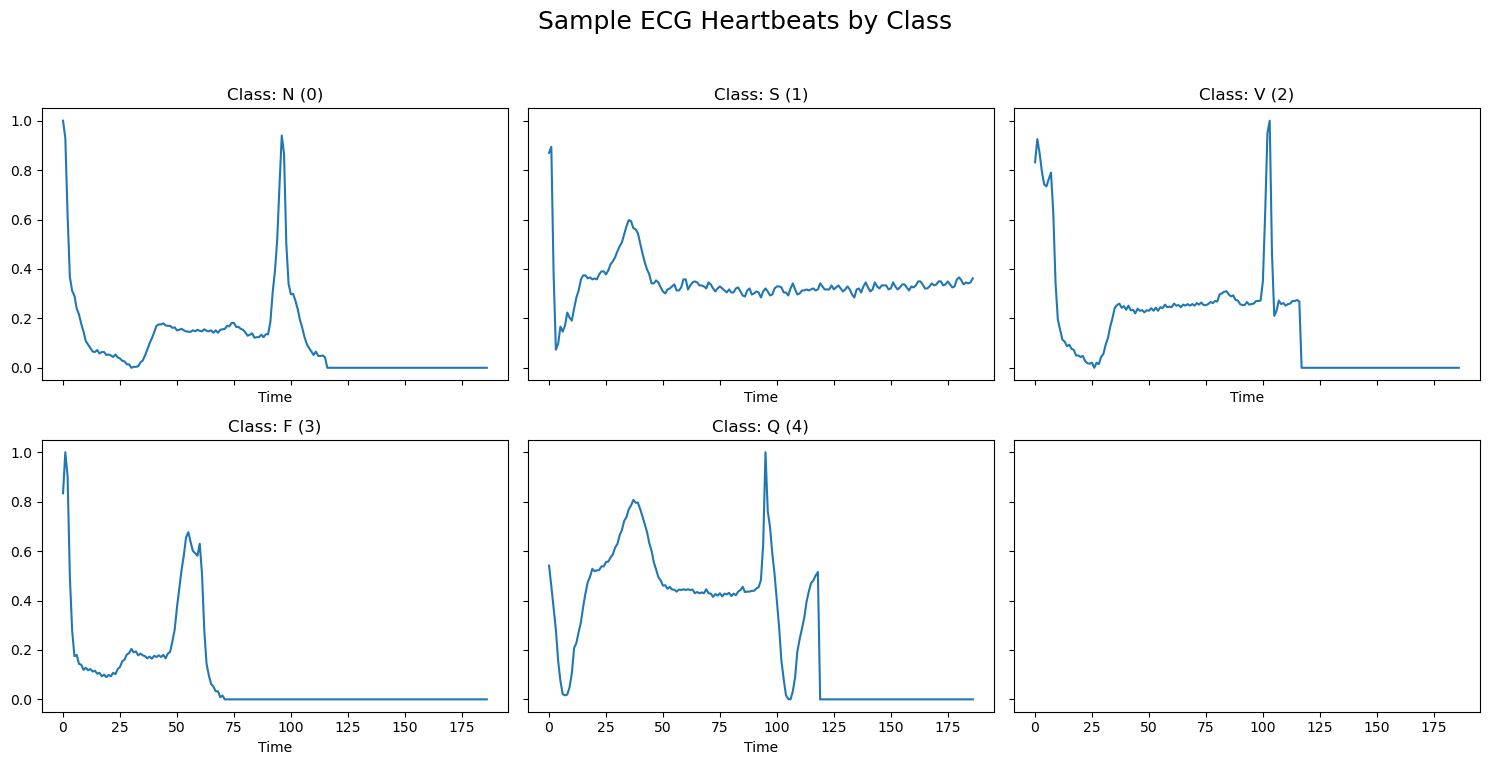

In [28]:
# Since we have 5 classes, we can make the subplot grid 5 columns long

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8), sharex=True, sharey=True)
# Makes it into a 1D array of list of items instead, probs dont need this because its already 1x6 but I always do this lol
axes = axes.flatten()

# Basically we are getting all the rows group by the last column(labels)
for ax, (label, group) in zip(axes, mitbih_train_df.groupby(LABEL_COL)):
    # Now we can grab a random sample from the group
    # We dont want a dataframe so we do .iloc[0,:-1],
    # The 0 is there because pandas makes it a dataframe
    # so we grab that row out of the dataframe and makes it into a series
    # then we get all the values up until the last column(which are
    # the labels)

    print(label)
    signal = group.sample(
        n=1,
        random_state=5,
    ).iloc[0, :-1]

    # Plot
    ax.plot(signal)
    ax.set_title(f"Class: {CLASSES[label]} ({int(label)})")
    ax.set_xlabel("Time")

fig.suptitle("Sample ECG Heartbeats by Class", fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

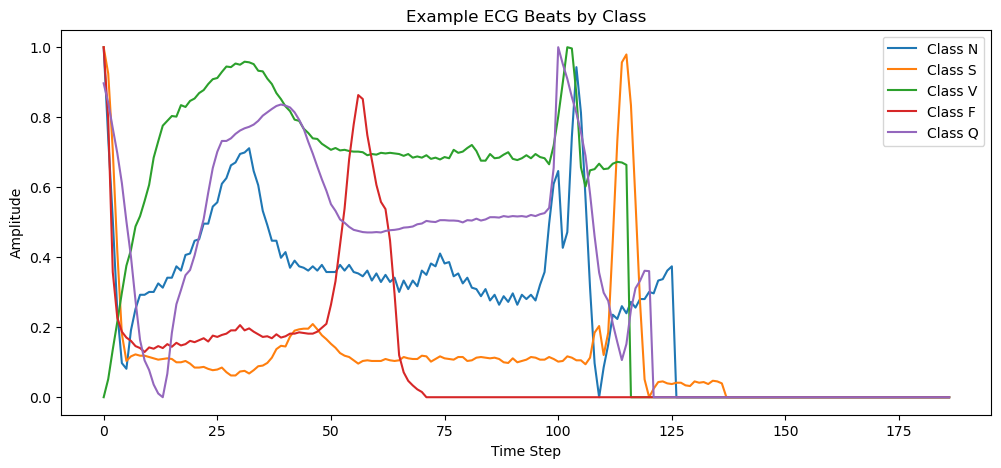

In [47]:
plt.figure(figsize=(12, 5))
random_number = random.randint(1, 100)
for label, group in mitbih_train_df.groupby(LABEL_COL):
    signal = group.sample(
        n=1,
        random_state=random_number,
    ).iloc[0, :-1]
    plt.plot(signal, label=f"Class {CLASSES[label]}")

plt.title("Example ECG Beats by Class")
plt.xlabel("Time Step")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

#### Analysis of visualization of classifications
1. From the __Visual__ analysis of all the signals, the following can be said:
   * after doing a couple of iteration of random state, it is clearly to me there is alot of variance. However, the __R Peak__ almost always exists in all classifications.
   * there seems to exist a __P wave__ seems to exist in all classification but __T wave__ is very hard to visual infer.
   * 

#### (Side thought) Is PCA relevant to reduce the dimentionality?
- To __reduce the dimentionality__ means we are reducing the number of timesetps to reduce redundancy. As in, between timestep 0 and 5, maybe they have the same values and thus dont provide information about the heart beat itself. Therefore, we can condense these timesteps, and reduce the total data we are loading.
- To do a PCA, we must first check if neigbouring points actually are related to each other. To do this, we can do a correlation matrix of all the rows.



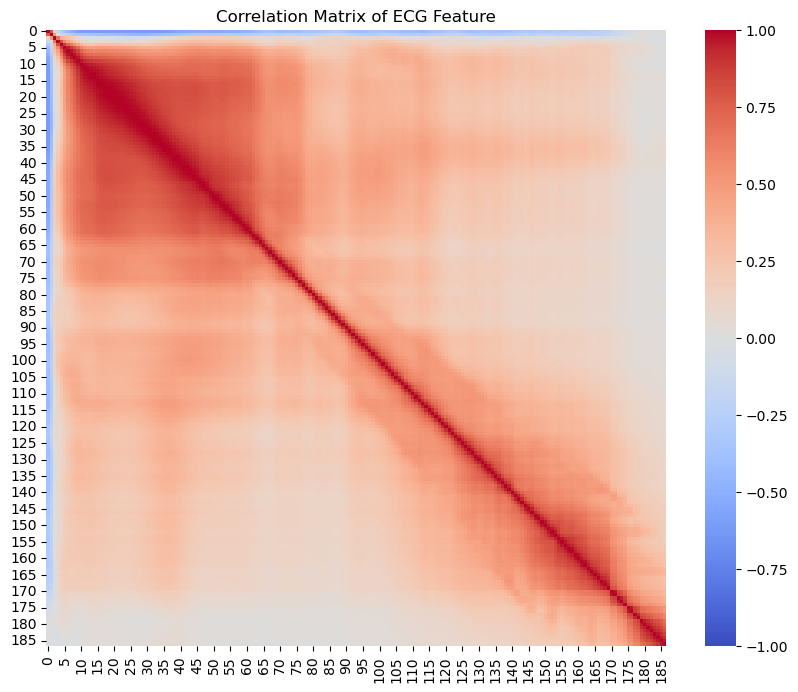

In [103]:
# Correlation Matrixs
sampled_df = mitbih_train_df.sample(n=3000, random_state=RANDOM_SEED)
correlation_matrix = sampled_df.iloc[:, :-1].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix of ECG Feature")
plt.show()

#### Analysis of correlation martix of timesteps
- From the correlation matrix of timesteps, or columns, aka the dimensions, we can see that there exist __medium to high positive correlation__ between timesteps that are adjacent to each other

### Goal: Identify normal(N,0) vs Anomoly(1,2,3,4)

#### Method to mathematically find the 3 peaks(P,R,T)
- We can assume that __P Wave__ and the __T Wave__ are relative to the __R wave__. The __R wave__ has a __peak__, and should be the highest peak. Therefore, we should be able to locate the __R wave__ and the find the  __P Wave__ and the __T Wave__ relative to the __R wave__.
- Locating the __R wave__ can be done through using a bandpass filter and locating the highest peak. 
- Then maybe we can use a moving average to find the __P wave__ and __T wave__ relative to the __R wave__.

But this is just practice, so I wont be implementing this algorithm and instead I am going to infer where the peaks might be through the visuals of the __Normal(0,N)__ graph. Thus, using visual analysis of the graphs(not recomended) is used to find informative region in the timesteps of a heatbeat. After looking at the graph, we can 

### Outlier detection
- Within each classification, we are going to use __Z-scores__ to detect the outliers

### Resources
1. M. Kachuee, S. Fazeli and M. Sarrafzadeh, "ECG Heartbeat Classification: A Deep Transferable Representation," _2018 IEEE International Conference on Healthcare Informatics (ICHI)_, New York, NY, USA, 2018, pp. 443-444, doi: 10.1109/ICHI.2018.00092.
   